In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.algorithms.one_plus_one_cma import OnePlusOneCMAES
import ioh 

import importlib.util

# The path to the lumapi.py file
file_path = 'C:\\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py'
spec_win = importlib.util.spec_from_file_location('lumapi', file_path)
lumapi = importlib.util.module_from_spec(spec_win)
spec_win.loader.exec_module(lumapi)

import scipy.io

In [3]:

def immersed_grating_fdtd(params, polarization, wavelength_i, polarization_angle, mesh_accuracy, run_switch=1):
    fdtd = lumapi.FDTD(hide=True)

    fdtd.switchtolayout
    fdtd.deleteall
    #etch slab from y=0.4 to y=0.6
    #coating slab from y=0 to y=0.4 #0.4 mircrons coating width
    #gratings at y=0
    #immersion slab from y=0 to y=-0.8
    # all slabs are 1 period + some "extra" in width 

    period = 2.07e-6
    incidence_angle = 62.6
    #polarization_angle = 45
    #wavelength_i = 2.345e-6

    #addstructuregroup();
    # Add and configure the "alGrating" structure group
    fdtd.addstructuregroup()
    fdtd.set("name", "alGrating")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "coatingSlab")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "etchSlab")
    fdtd.set("enabled", 1)

    fdtd.addstructuregroup()
    fdtd.set("name", "immersionSlab")
    fdtd.set("enabled", 1)

    widths_x, widths_z, H = params[:5], params[5:10], params[-1] 

    ################################### Al gratings ###################################
  
    #widths_x, widths_z, H = params[:5], params[5:10], params[-1] 

    material = "Al (Aluminium) - Palik"

    period = 2.07e-6
    
    centers_z = np.array([0.5, 1.5, 2.5, 3.5, 4.5])*(period/5)
    centers_x = np.array([0.5, 1.5, 2.5, 3.5, 4.5])*(period/5)



    # Loop over widths in x-dimension
    for xi in range(len(widths_x)):
        center_x = centers_x[xi]
        width_x = widths_x[xi]
        
        # Loop over widths in z-dimension
        for zi in range(len(widths_z)):
            center_z = centers_z[zi]
            width_z = widths_z[xi]

            #print(f"{width_x} - {width_z}")
            
            # Create a rectangular pillar
            fdtd.addrect()
            fdtd.set('x', center_x)  # Center position in x
            fdtd.set('x span', width_x)  # Width in x-dimension
            fdtd.set('y', -H / 2)  # Base position in y
            fdtd.set('y span', H)  # Height in y-dimension
            fdtd.set('z', center_z)  # Center position in z
            fdtd.set('z span', width_z)  # Width in z-dimension
            
            fdtd.set('material', material)  # Set the material
            fdtd.set('name', f'grating_x{xi+1}_z{zi+1}')  # Unique name for each rectangle
            fdtd.addtogroup("alGrating")  # Add to the group


    ################################### Coating slab ###################################
    coating_material = "Al (Aluminium) - Palik"
    offset = period * 0.2  # 20% of the period

    ymin = 0
    ymax = 0.4e-6  # 0.4 microns coating width

    slabs_width = period + offset
    slabs_center = period / 2

    # Add a rectangle and set properties
    fdtd.addrect()
    fdtd.set("x", slabs_center)  # Center position in x
    fdtd.set("x span", slabs_width)  # Width in x-dimension
    fdtd.set("y min", ymin)  # Base position in y
    fdtd.set("y max", ymax)  # Height in y-dimension
    fdtd.set("z", slabs_center)  # Center position in z
    fdtd.set("z span", slabs_width)  # Width in z-dimension
    fdtd.set("material", coating_material)  # Set the material
    fdtd.set("name", "coatingSlab")
    fdtd.addtogroup("coatingSlab")  # Add to the group


    ################################### Etch slab ###################################
    coating_material = "etch"  # Assuming "etch" is a placeholder for the actual material name
    offset = period * 0.2  # 20% of the period

    ymin = 0.4e-6  # Start of etch slab in y-direction
    ymax = 0.6e-6  # End of etch slab in y-direction

    slabs_width = period + offset  # Width of the slab including offset
    slabs_center = period / 2  # Center position of the slab

    # Add a rectangle for the etch slab
    fdtd.addrect()
    fdtd.set("x", slabs_center)  # Center position in x
    fdtd.set("x span", slabs_width)  # Width in x-dimension
    fdtd.set("y min", ymin)  # Base position in y
    fdtd.set("y max", ymax)  # Height in y-dimension
    fdtd.set("z", slabs_center)  # Center position in z
    fdtd.set("z span", slabs_width)  # Width in z-dimension
    fdtd.set("material", coating_material)  # Set the material
    fdtd.set("name", "etchSlab")
    fdtd.addtogroup("etchSlab")  # Add to the group

    ################################### Immersion slab ###################################
    immersion_material = "Si (Silicon) - Palik"  # Silicon material from Palik's database
    offset = period * 0.2  # 20% of the period

    ymin = -0.8e-6  # Start of immersion slab in y-direction
    ymax = 0.0  # End of immersion slab in y-direction

    slabs_width = period + offset  # Width of the slab including offset
    slabs_center = period / 2  # Center position of the slab

    # Add a rectangle for the immersion slab
    fdtd.addrect()
    fdtd.set("x", slabs_center)  # Center position in x
    fdtd.set("x span", slabs_width)  # Width in x-dimension
    fdtd.set("y min", ymin)  # Base position in y
    fdtd.set("y max", ymax)  # Height in y-dimension
    fdtd.set("z", slabs_center)  # Center position in z
    fdtd.set("z span", slabs_width)  # Width in z-dimension

    # Mesh settings
    fdtd.set("override mesh order from material database", 1)
    fdtd.set("mesh order", 3)  # Set the mesh order explicitly

    # Set the material and other properties
    fdtd.set("material", immersion_material)  # Set the material
    fdtd.set("name", "immersionSlab")
    fdtd.addtogroup("immersionSlab")  # Add to the group


    ################################### index monitor ###################################
    offset = period * 0.05  # 5% of the period
    ymin = -0.75e-6  # Start of index monitor region in y-direction
    ymax = 0.5e-6  # End of index monitor region in y-direction

    slabs_width = period + offset  # Width of the index monitor including offset
    slabs_center = period / 2  # Center position of the index monitor

    # Add an index monitor
    fdtd.addindex()

    # Set properties for the index monitor
    fdtd.set("x", slabs_center)  # Center position in x
    fdtd.set("x span", slabs_width)  # Width in x-dimension
    fdtd.set("y min", ymin)  # Base position in y
    fdtd.set("y max", ymax)  # Height in y-dimension
    fdtd.set("z", slabs_center / 5)  # Center position in z
    # fdtd.set("z span", slabs_width)  # Width in z-dimension, commented out as in original script

    # Further monitor settings
    fdtd.set("name", "index_monitor")
    fdtd.set("monitor type", 3)  # 2D z-normal monitor type



    ################################### FDTD ###################################
    ymin = -0.75e-6; ymax = 0.5e-6; #immersion slab from y=0 to y=-0.8

    slabs_width = period
    slabs_center = slabs_width/2

    fdtd.addfdtd()
    fdtd.set("dimension", '3D')  # 3D
    fdtd.set('x',slabs_center)  # Center position in x
    fdtd.set('x span', slabs_width)  # Width in x-dimension

    fdtd.set('y min', ymin)  # Base position in y
    fdtd.set('y max',ymax)  # Height in y-dimension

    fdtd.set('z', slabs_center/5);  # Center position in z
    fdtd.set('z span', slabs_width/5)  # Width in z-dimension

    fdtd.set('x min bc', 'Bloch')
    fdtd.set('z min bc', 'Bloch')

    fdtd.set("mesh accuracy", mesh_accuracy)  # Set the mesh order explicitly #2, 15, 50, 120, 240, 460 mins


    ################################### Source ###################################
    fdtd.addplane()
    fdtd.set('injection axis', 'y')
    fdtd.set('x', period / 2)
    y_source = ymin * 0.90
    fdtd.set('y', y_source)
    fdtd.set('z', period / 5 / 2)
    fdtd.set('angle theta', incidence_angle)
    fdtd.set('angle phi', 90)
    if polarization == "U":
        fdtd.set('polarization angle', polarization_angle)
    else:
        fdtd.set("polarization definition", polarization)
    fdtd.set('plane wave type', 'Bloch/periodic')
    fdtd.set('wavelength start', wavelength_i)
    fdtd.set('wavelength stop', wavelength_i)

    ################################### reflection monitor ###################################
    offset = period * 0.5  # Additional offset
    slabs_width = period + offset
    slabs_center = period / 2

    fdtd.addpower()
    fdtd.set("name", "reflection_grating")
    fdtd.set("monitor type", "3D")
    fdtd.set('x', slabs_center)
    fdtd.set('x span', slabs_width)
    y_monitor = ymin * 0.95
    fdtd.set('y', y_monitor)
    fdtd.set('y min', y_monitor)
    fdtd.set('y max', y_monitor)
    fdtd.set('z', slabs_center / 5)
    fdtd.set('z span', slabs_width / 5)


    filename = '2dDesign_field' +  f"{polarization}" + f"{wavelength_i*1e6}" + ".fsp"
    # Run the simulation
    fdtd.save(filename)
    index_profile = fdtd.getresult("index_monitor","index")
        
    # Run the simulation

    if run_switch == 1:
        fdtd.run()
        Tr = fdtd.transmission("reflection_grating", 1)
        
        mname = "reflection_grating"  # monitor name
        G = fdtd.grating(mname)  # power to each order (fraction of transmitted power)
        n_orders = fdtd.gratingn(mname)  # power to each order (fraction of transmitted power)
        m_orders = fdtd.gratingm(mname)  # power to each order (fraction of transmitted power)
        u1_vectors = fdtd.gratingu1(mname)
        u2_vectors = fdtd.gratingu1(mname)
        return n_orders, m_orders, u1_vectors, u2_vectors, np.array(-Tr * G), index_profile
    else:
        return np.zeros([1,2]),np.zeros([1,2]), np.zeros([1,2]),  np.zeros([1,2]), np.zeros([1,2]), index_profile



In [4]:
#######   CMA-ES analysis ########

filename = 'CMA_ES_run_result.txt'

raw_y = []
matrix = []

with open(filename, 'r') as f:
    next(f)
    for line in f:
        line = line.strip()
        if not line:
            continue
        data = line.split()
        if len(data) == 13:
            raw_y.append(float(data[1]))
            row = [float(val) for val in data[2:]]
            matrix.append(row)

eff_array = np.array(raw_y)*-1
params_norm_mat = np.array(matrix)

params_mat = []

for i in range(len(params_norm_mat)):
    params_norm = params_norm_mat[i]
    widths_x_norm, widths_z_norm, H_norm = params_norm[:5], params_norm[5:10], params_norm[-1] 

    period = 2.07e-6
    widths_x = (widths_x_norm + 1) * (period/5.1 / 2)
    widths_z = (widths_z_norm + 1) * (period/5.1 / 2)
    H = (H_norm + 1) * (0.6e-6 - 0.2e-6) / 2 + 0.2e-6

    params = np.concatenate([widths_x, widths_z, [H]])
    params_mat.append(params)

params_mat = np.array(params_mat)
eff_array = eff_array

best_params_mat = params_mat[np.where(eff_array >= 0.802)[0][0]]

best_params_mat

array([1.63539741e-07, 1.79211062e-07, 1.52327850e-07, 2.08341644e-07,
       1.77976368e-07, 2.09259547e-07, 1.71454447e-07, 2.11643294e-07,
       1.74291159e-07, 1.85095341e-07, 2.00000000e-07])

In [ ]:
#######   CMA-ES best point at different polarization and SWIR-3 Band ########

In [ ]:
import numpy as np

wavelength_arr = np.linspace(2.304e-6, 2.400e-6, 7)

pol_arr = ["S", "P", "U"]

mesh_accuracy = 3

npz_filename = "cmaes_results_final.npz"

results = {
    "wavelength": [],
    "polarization": [],
    "efficiency": [],
    "n_orders": [],
    "m_orders": [],
    "u1_vectors": [],
    "u2_vectors": [],
    "index_profile": []
}

for wavelength_i in wavelength_arr:
    for pol in pol_arr:
        
        n_orders, m_orders, u1_vectors, u2_vectors, eff_val, index_profile = immersed_grating_fdtd(
            best_params_mat, pol, wavelength_i, 45, mesh_accuracy
        )

        eff_5_val = eff_val[0][0]

        results["wavelength"].append(wavelength_i)
        results["polarization"].append(pol)
        results["efficiency"].append(eff_val)
        results["n_orders"].append(n_orders)
        results["m_orders"].append(m_orders)
        results["u1_vectors"].append(u1_vectors)
        results["u2_vectors"].append(u2_vectors)
        results["index_profile"].append(index_profile)

        #np.savez(npz_filename, **results)

        print(f"wavelength: {wavelength_i:.4e} m, Polarization: {pol}, eff_5_val: {eff_5_val:.4f}")

wavelength: 2.3040e-06 m, Polarization: S, eff_5_val: 0.8013
wavelength: 2.3040e-06 m, Polarization: P, eff_5_val: 0.7769
wavelength: 2.3040e-06 m, Polarization: U, eff_5_val: 0.7891
wavelength: 2.3200e-06 m, Polarization: S, eff_5_val: 0.7988
wavelength: 2.3200e-06 m, Polarization: P, eff_5_val: 0.7792
wavelength: 2.3200e-06 m, Polarization: U, eff_5_val: 0.7890
wavelength: 2.3360e-06 m, Polarization: S, eff_5_val: 0.7895
wavelength: 2.3360e-06 m, Polarization: P, eff_5_val: 0.7832
wavelength: 2.3360e-06 m, Polarization: U, eff_5_val: 0.7863
wavelength: 2.3520e-06 m, Polarization: S, eff_5_val: 0.7900
wavelength: 2.3520e-06 m, Polarization: P, eff_5_val: 0.7874
wavelength: 2.3520e-06 m, Polarization: U, eff_5_val: 0.7887
wavelength: 2.3680e-06 m, Polarization: S, eff_5_val: 0.7848
wavelength: 2.3680e-06 m, Polarization: P, eff_5_val: 0.7738
wavelength: 2.3680e-06 m, Polarization: U, eff_5_val: 0.7793
wavelength: 2.3840e-06 m, Polarization: S, eff_5_val: 0.7861
wavelength: 2.3840e-06 m

In [9]:
results = np.load('cmaes_results.npz', allow_pickle=True)
eff_array = np.array(results["efficiency"])

u1_arr_cmaes = np.array(results["u1_vectors"])
u2_arr_cmaes = np.array(results["u2_vectors"])

np.shape(eff_array)

s_pol_arr_eff = eff_array[:,0,0][::3]
u_pol_arr_eff = eff_array[:,0,0][2::3]
p_pol_arr_eff = eff_array[:,0,0][1::3]

wavelength_arr = np.linspace(2.304e-6, 2.400e-6, 7)


S (90°) - 0.795
S (90°) - 0.659
P (0°) - 0.712
P (0°) - 0.581
U - 0.754
U - 0.620


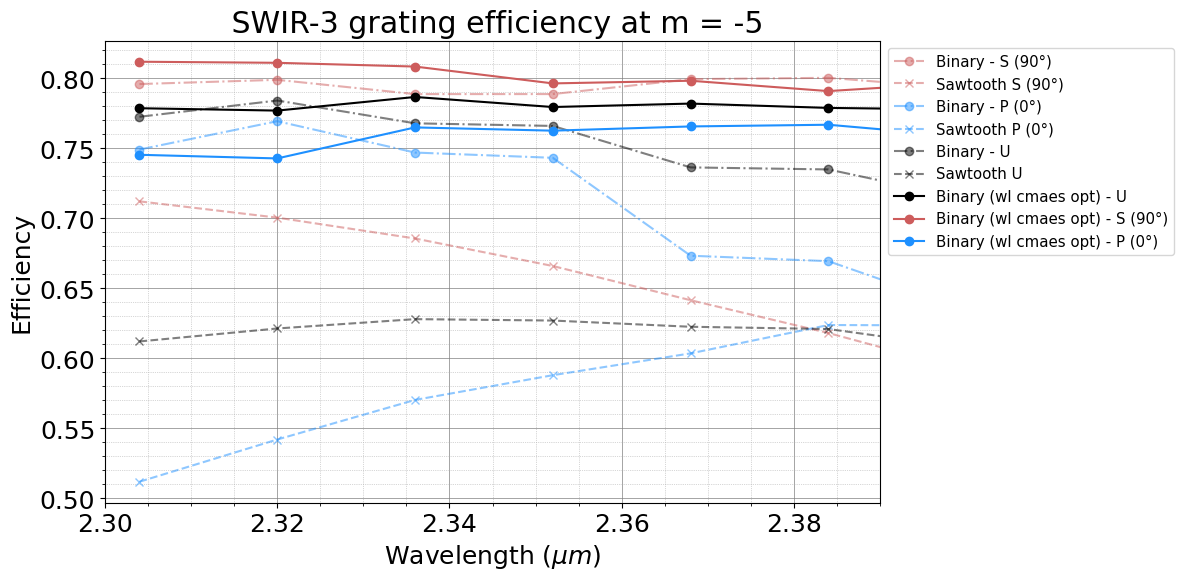

In [10]:

import matplotlib.pyplot as plt
import numpy as np

# Convert wavelength to micrometers for easier reading on the plot
wavelength_microns = wavelength_arr * 1e6
sawtooth_wavelength_microns = sawtooth_data['wavelength_range'] * 1e6

# Apply wavelength filter: only include wavelengths between 2.3 and 2.4 µm
low_limit = 2.18
upper_limit = 2.55
low_limit = 2.3
upper_limit = 2.4

wavelength_filter = (low_limit <= wavelength_microns) & (wavelength_microns <= upper_limit)
filtered_wavelengths = wavelength_microns[wavelength_filter]

sawtooth_wavelength_filter = (low_limit <= sawtooth_wavelength_microns) & (sawtooth_wavelength_microns <= upper_limit)
sawtooth_filtered_wavelengths = sawtooth_wavelength_microns[sawtooth_wavelength_filter]

# Define colors for each polarization
colors = ['indianred', 'dodgerblue', 'k']
labels = ['S (90°)', 'P (0°)', 'U']
polarization_keys = ['eff_arr_90', 'eff_arr_0', 'eff_arr_45']  # Keys for sawtooth data


font_size = 24
# Start the plot
plt.figure(figsize=(10, 6))
# Loop through each polarization for "binary" data
for i, label in enumerate(labels):
    # Extract the -5th order efficiency for filtered wavelengths in this polarization (binary data)
    binary_neg_5th_order_eff = [
        eff_arr[i][wl][np.where(norders_arr[i][wl] == -5)[0][0]][0]
        for wl in range(len(wavelength_arr)) if wavelength_filter[wl]
    ]
    
    # Extract -5th order efficiency for sawtooth data using binary's `norders_arr`
    sawtooth_neg_5th_order_eff = [
        sawtooth_data[polarization_keys[i]][wl][np.where(norders_arr_sawtooth[i][wl] == -5)[0][0]]
        for wl in range(len(sawtooth_data['wavelength_range'])) if sawtooth_wavelength_filter[wl]
    ]

    sawtooth_neg_5th_order_eff = [
        sawtooth_data[polarization_keys[i]][wl][0]
        for wl in range(len(sawtooth_data['wavelength_range'])) if sawtooth_wavelength_filter[wl]
    ]

    # Plot both "binary" and "sawtooth" for this polarization
    plt.plot(filtered_wavelengths, binary_neg_5th_order_eff, color=colors[i], linestyle='-.', marker='o', label=f'Binary - {label}', alpha = 0.5)
    print(f"{label} - {np.mean(binary_neg_5th_order_eff):0.3f}")
    plt.plot(sawtooth_filtered_wavelengths, sawtooth_neg_5th_order_eff, color=colors[i], linestyle='--', marker='x', label=f'Sawtooth {label}', alpha = 0.5)
    print(f"{label} - {np.mean(sawtooth_neg_5th_order_eff):0.3f}")
    

# Customize the plot
lowerlimit_plot = 2.30
upperlimit_plot = 2.39

plt.plot(wavelength_arr*1e6, u_pol_arr_eff,  linestyle='-', marker='o', color = 'k', label = 'Binary (wl cmaes opt) - U')
plt.plot(wavelength_arr*1e6, s_pol_arr_eff,  linestyle='-', marker='o', color = 'indianred', label = 'Binary (wl cmaes opt) - S (90°)')
plt.plot(wavelength_arr*1e6, p_pol_arr_eff,  linestyle='-', marker='o', color = 'dodgerblue', label = 'Binary (wl cmaes opt) - P (0°)')

plt.xlim(lowerlimit_plot, upperlimit_plot)
plt.xlabel(r'Wavelength ($\mu m$)', fontsize = font_size * 0.75)
plt.ylabel('Efficiency', fontsize = font_size * 0.75)
plt.title(r' SWIR-3 grating efficiency at m = -5', fontsize = font_size * 0.9)

plt.legend(fontsize=font_size * 0.45, loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)

plt.tick_params(axis='y', labelsize= font_size * 0.75)
plt.tick_params(axis='x', labelsize= font_size * 0.75)

# Enable minor ticks on both x and y axes
plt.minorticks_on()
# Add minor grid
# Customize major gridlines
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')

# Turn on minor ticks and customize minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5')

plt.savefig('effvsWl_swir3_m5.png', dpi=1000)

Sawtooth - S - 0.659
Sawtooth - P - 0.581
Sawtooth - Unpolarized - 0.620
Meta - S - 0.802
Meta - P - 0.758
Meta - U - 0.7801


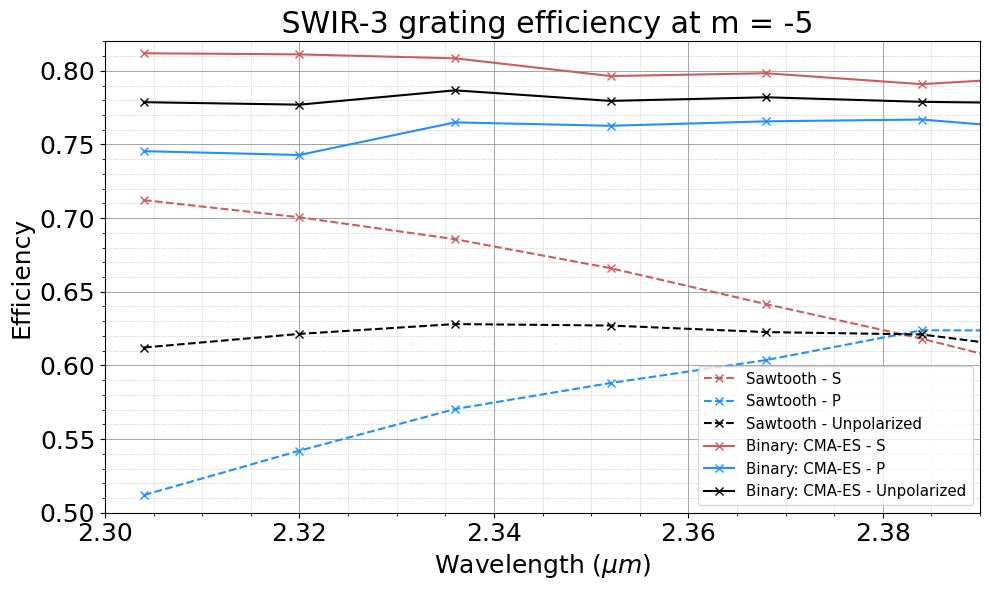

In [15]:



import matplotlib.pyplot as plt
import numpy as np

# Convert wavelength to micrometers for easier reading on the plot
wavelength_microns = wavelength_arr * 1e6
sawtooth_wavelength_microns = sawtooth_data['wavelength_range'] * 1e6

# Apply wavelength filter: only include wavelengths between 2.3 and 2.4 µm
low_limit = 2.18
upper_limit = 2.55
low_limit = 2.3
upper_limit = 2.4

wavelength_filter = (low_limit <= wavelength_microns) & (wavelength_microns <= upper_limit)
filtered_wavelengths = wavelength_microns[wavelength_filter]

sawtooth_wavelength_filter = (low_limit <= sawtooth_wavelength_microns) & (sawtooth_wavelength_microns <= upper_limit)
sawtooth_filtered_wavelengths = sawtooth_wavelength_microns[sawtooth_wavelength_filter]

# Define colors for each polarization
colors = ['indianred', 'dodgerblue', 'k']
labels = ['S', 'P', 'Unpolarized']
polarization_keys = ['eff_arr_90', 'eff_arr_0', 'eff_arr_45']  # Keys for sawtooth data


font_size = 24
# Start the plot
plt.figure(figsize=(10, 6))
# Loop through each polarization for "binary" data
for i, label in enumerate(labels):
    # Extract the -5th order efficiency for filtered wavelengths in this polarization (binary data)
    binary_neg_5th_order_eff = [
        eff_arr[i][wl][np.where(norders_arr[i][wl] == -5)[0][0]][0]
        for wl in range(len(wavelength_arr)) if wavelength_filter[wl]
    ]
    
    # Extract -5th order efficiency for sawtooth data using binary's `norders_arr`
    sawtooth_neg_5th_order_eff = [
        sawtooth_data[polarization_keys[i]][wl][np.where(norders_arr_sawtooth[i][wl] == -5)[0][0]]
        for wl in range(len(sawtooth_data['wavelength_range'])) if sawtooth_wavelength_filter[wl]
    ]

    sawtooth_neg_5th_order_eff = [
        sawtooth_data[polarization_keys[i]][wl][0]
        for wl in range(len(sawtooth_data['wavelength_range'])) if sawtooth_wavelength_filter[wl]
    ]

    # Plot both "binary" and "sawtooth" for this polarization
    '''plt.plot(filtered_wavelengths, binary_neg_5th_order_eff, color=colors[i], linestyle='-.', marker='o', label=f'Binary - {label}', alpha = 0.5)
    print(f"{label} - {np.mean(binary_neg_5th_order_eff):0.3f}")'''
    plt.plot(sawtooth_filtered_wavelengths, sawtooth_neg_5th_order_eff, color=colors[i], linestyle='--', marker='x', label=f'Sawtooth - {label}', alpha = 1)
    print(f"Sawtooth - {label} - {np.mean(sawtooth_neg_5th_order_eff):0.3f}")
    

# Customize the plot
lowerlimit_plot = 2.30
upperlimit_plot = 2.39

'''plt.plot(wv_arr, unpol_eff,  linestyle='-', marker='o', color = 'k', label = 'Binary (wl cmaes opt) - U')
plt.plot(wv_arr, s_eff,  linestyle='-', marker='o', color = 'indianred', label = 'Binary (wl cmaes opt) - S (90°)')
plt.plot(wv_arr, p_eff,  linestyle='-', marker='o', color = 'dodgerblue', label = 'Binary (wl cmaes opt) - P (0°)')'''

plt.plot(wavelength_arr*1e6, s_pol_arr_eff,  linestyle='-', marker='x', color = 'indianred', label = 'Binary: CMA-ES - S')
plt.plot(wavelength_arr*1e6, p_pol_arr_eff,  linestyle='-', marker='x', color = 'dodgerblue', label = 'Binary: CMA-ES - P')
plt.plot(wavelength_arr*1e6, u_pol_arr_eff,  linestyle='-', marker='x', color = 'k', label = 'Binary: CMA-ES - Unpolarized')

print(f"Meta - S - {np.mean(s_pol_arr_eff):0.3f}")
print(f"Meta - P - {np.mean(p_pol_arr_eff):0.3f}")
print(f"Meta - U - {np.mean(u_pol_arr_eff):0.4f}")


plt.xlim(lowerlimit_plot, upperlimit_plot)
plt.xlabel(r'Wavelength ($\mu m$)', fontsize = font_size * 0.75)
plt.ylabel('Efficiency', fontsize = font_size * 0.75)
plt.title(r' SWIR-3 grating efficiency at m = -5', fontsize = font_size * 0.9)

plt.legend(fontsize=font_size * 0.45, loc='lower right')
plt.grid(True)

plt.tick_params(axis='y', labelsize= font_size * 0.75)
plt.tick_params(axis='x', labelsize= font_size * 0.75)

# Enable minor ticks on both x and y axes
plt.minorticks_on()
# Add minor grid
# Customize major gridlines
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')

# Turn on minor ticks and customize minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5')

plt.ylim(0.5, 0.82)
# Show the plot
#plt.savefig('effvsWl_compar.png', dpi=1000)
#plt.savefig('effvsWl_swir3.png', dpi=1000)

plt.tight_layout()
plt.savefig('effvsWl_swir3_m5.png', dpi=1000)


In [12]:



plt.figure(figsize=(10, 6))
plt.plot(sawtooth_filtered_wavelengths, sawtooth_pol_sens, label = 'Sawtooth', ls = '-', color = 'indianred')
plt.plot(wavelength_arr*1e6, binary_pol_sens_cmaes,  label = 'Binary: CMA-ES', ls = '-', color = 'dodgerblue')

#plt.ylim(-0.175, 0.175)
plt.axhline(-0.15, ls = '--', color = 'k')
plt.axhline(0.15, ls = '--', color = 'k')
plt.legend()
plt.xlim(lowerlimit_plot, upperlimit_plot)


plt.xlabel(r'Wavelength ($\mu m$)', fontsize = font_size * 0.75)
plt.ylabel(r'Polarization sensitivity [$\eta_{pol}$]', fontsize = font_size * 0.75)

plt.legend(loc = 'lower right' ,fontsize = font_size * 0.6)
plt.grid(True)

plt.tick_params(axis='y', labelsize= font_size * 0.75)
plt.tick_params(axis='x', labelsize= font_size * 0.75)

# Enable minor ticks on both x and y axes
plt.minorticks_on()
# Add minor grid
# Customize major gridlines
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')

# Turn on minor ticks and customize minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5')
plt.tight_layout()

plt.savefig('polSenVswl_swir3_m5.png', dpi=1000)

NameError: name 'sawtooth_pol_sens' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
#### dispersion ####

In [338]:
results = np.load('cmaes_results.npz', allow_pickle=True)
eff_array = np.array(results["efficiency"])

u1_arr_cmaes = np.array(results["u1_vectors"])
u2_arr_cmaes = np.array(results["u2_vectors"])




0 -> 0, 0, o
1 -> 1, 0, s
2 -> 2, 0, ^


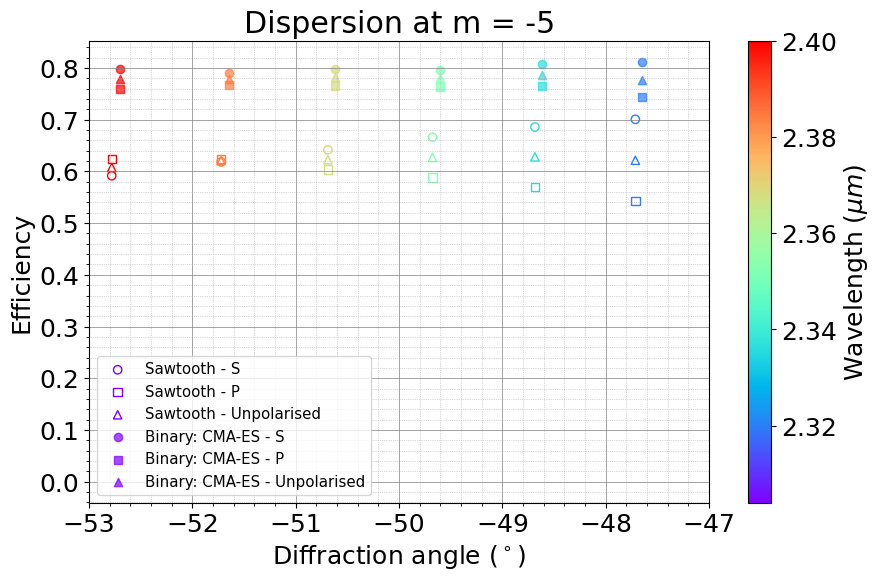

In [391]:
import matplotlib.cm as cm
%matplotlib inline

wavelength_arr = np.linspace(2.304e-6, 2.400e-6, 7)

# Apply wavelength filter: only include wavelengths between 2.3 and 2.4 µm
low_limit = 2.3
upper_limit = 2.4
wavelength_filter = (low_limit <= wavelength_microns) & (wavelength_microns <= upper_limit)
filtered_wavelengths = wavelength_microns[wavelength_filter]

sawtooth_wavelength_filter = (low_limit <= sawtooth_wavelength_microns) & (sawtooth_wavelength_microns <= upper_limit)
sawtooth_filtered_wavelengths = sawtooth_wavelength_microns[sawtooth_wavelength_filter]


# Filter wavelengths within the desired range
wavelength_arr_req = wavelength_arr[wavelength_filter]
sawtooth_wavelength_arr_req = sawtooth_data['wavelength_range'][sawtooth_wavelength_filter]

# Define symbols for each polarization
symbols = ['o', 's', '^']  # Circle, square, and triangle for S, P, U polarizations

# Create a colormap based on the wavelength range
norm = plt.Normalize(vmin=wavelength_arr.min() * 1e6, vmax=wavelength_arr.max() * 1e6)
cmap = cm.rainbow

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define the correct keys for each polarization
theta_keys = ['theta_arr_90', 'theta_arr_0', 'theta_arr_45']
efficiency_keys = ['eff_arr_90', 'eff_arr_0', 'eff_arr_45']
labels = ['S (90°)', 'P (0°)', 'U']
labels = ['S', 'P', 'Unpolarised']


# Loop through each polarization for "binary"  (old thesis data)
for i, label in enumerate(labels):
    label_added = False  # For single label per polarization

    # Loop through each wavelength for binary
    for wl in range(len(wavelength_arr)):
        wavelength_i_micron = wavelength_arr[wl] * 1e6
        if wavelength_filter[wl]:
            theta_deg_i = 90 - np.arccos(u1_arr[i][wl]) * 180 / np.pi  # Use computed angle for binary data
            efficiencies = eff_arr[i][wl].flatten()
            color = cmap(norm(wavelength_i_micron))

            #ax.scatter(theta_deg_i, efficiencies, color=color, marker=symbols[i], 
            #           label=f'Binary: - {label}' if not label_added else "", alpha=0.0)
            #label_added = True

# Loop through each polarization for "sawtooth" data
for i, label in enumerate(labels):
    label_added = False  # For single label per polarization

    # Loop through each wavelength for sawtooth
    for wl in range(len(sawtooth_data['wavelength_range'])):
        wavelength_i_micron = sawtooth_data['wavelength_range'][wl] * 1e6
        if sawtooth_wavelength_filter[wl]:
            theta_deg_i = sawtooth_data[theta_keys[i]][wl]  # Directly use theta in degrees for sawtooth
            efficiencies = sawtooth_data[efficiency_keys[i]][wl].flatten()
            color = cmap(norm(wavelength_i_micron))

            ax.scatter(theta_deg_i, efficiencies, edgecolor=color, facecolors='none', marker=symbols[i], 
                       label=f'Sawtooth - {label}' if not label_added else "", alpha=1)
            label_added = True

for i in range(len(u1_arr_cmaes)):
    # Determine polarization and wavelength
    polarization_idx = i % 3  # Determine the polarization index (0, 1, 2 for s, p, u)
    wavelength_idx = i // 3 

    wavelength_i_micron = wavelength_arr[wavelength_idx] * 1e6

    polarization = pol[polarization_idx]
    wavelength = wavelength_arr[wavelength_idx]

    u1_value = u1_arr_cmaes[i]  # Adjust this if needed
    theta_deg_i = 90 - np.arccos(u1_value) * 180 / np.pi  # Use computed angle for binary data
    efficiencies = eff_array[i].flatten()

    color = cmap(norm(wavelength_i_micron))

    if wavelength_idx == 0:
        label_added = True
        print(f"{i} -> {polarization_idx}, {wavelength_idx}, {symbols[polarization_idx]}")
    else:
        label_added = False
    ax.scatter(theta_deg_i, efficiencies, color=color, marker=symbols[polarization_idx], 
                       label=f'Binary: CMA-ES - {labels[polarization_idx]}' if label_added else "", alpha=0.7)
    
    

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=font_size * 0.75)
cbar.set_label(r'Wavelength ($\mu m$)', fontsize=font_size * 0.75)


ax.set_xlim(-53, -47)

plt.xlabel(r'Diffraction angle ($^\circ$)', fontsize = font_size * 0.75)
plt.ylabel('Efficiency', fontsize = font_size * 0.75)
#plt.title(r'Dispersion of all grating orders', fontsize = font_size * 0.9)
plt.title(r'Dispersion at m = -5', fontsize = font_size * 0.9)
plt.legend(fontsize = font_size * 0.45)
plt.grid(True)

plt.tick_params(axis='y', labelsize= font_size * 0.75)
plt.tick_params(axis='x', labelsize= font_size * 0.75)

# Enable minor ticks on both x and y axes
plt.minorticks_on()
# Add minor grid
# Customize major gridlines
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='grey')

# Turn on minor ticks and customize minor gridlines
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.5')

# Show the plot
#plt.savefig('eff_dispersion_full.png', dpi=1000)

plt.savefig('eff_dispersion_swir3_m5.png', dpi=1000)
#plt.savefig('eff_dispersion_swir3_allm.png', dpi=1000)

In [373]:
len(u1_arr_cmaes)

21